In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
from torch import nn


In [ ]:
from sklearn.datasets import make_moons
n_samples = 1000

X ,y = make_moons(n_samples, noise = 0.03, random_state = 42)
X1 = torch.from_numpy(X).type(torch.float)
y1 = torch.from_numpy(y).type(torch.float)

moons = pd.DataFrame({"X1": X1[:, 0],
    "X2": X1[:, 1],
    "label": y1
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1.0
1,0.954574,-0.473756,1.0
2,0.918526,-0.425196,1.0
3,0.412768,-0.376385,1.0
4,-0.845320,0.528799,0.0
5,0.579542,-0.352979,1.0
6,0.294884,-0.209238,1.0
7,-0.014488,0.435896,1.0
8,1.626510,-0.281207,1.0
9,0.671598,0.786422,0.0


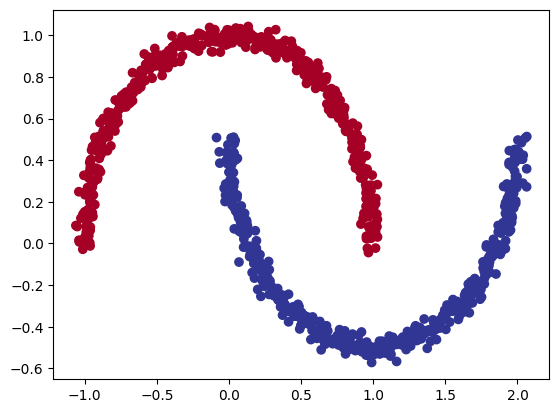

In [ ]:
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2,
                                                    random_state = 42)

class MoonModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return (self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

model_1 = MoonModelV0().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.01)

In [ ]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

def acc_fun(y_pred, y_true):
  correct = torch.eq(y_pred,y_true).sum()
  acc = (correct/len(y_true)) * 100
  return acc

torch.manual_seed(42)
epochs1 = 1000

X_train1, y_train1 = X_train1.to(device), y_train1.to(device)
X_test1, y_test1 = X_test1.to(device), y_test1.to(device)

for epoch in range(epochs1):
  model_1.train()

  y_logits = model_1(X_train1).squeeze().to(device)
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train1)
  acc = acc_fun(y_pred, y_train1)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test1).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test1)
    test_acc = acc_fun(test_pred, y_test1)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.06854 | Accuracy: 98.50% | Test Loss: 0.06277 | Test Accuracy: 99.00%
Epoch: 10 | Loss: 0.06823 | Accuracy: 98.50% | Test Loss: 0.06247 | Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.06792 | Accuracy: 98.50% | Test Loss: 0.06217 | Test Accuracy: 99.00%
Epoch: 30 | Loss: 0.06761 | Accuracy: 98.50% | Test Loss: 0.06187 | Test Accuracy: 99.00%
Epoch: 40 | Loss: 0.06731 | Accuracy: 98.50% | Test Loss: 0.06158 | Test Accuracy: 99.00%
Epoch: 50 | Loss: 0.06700 | Accuracy: 98.50% | Test Loss: 0.06129 | Test Accuracy: 99.00%
Epoch: 60 | Loss: 0.06670 | Accuracy: 98.50% | Test Loss: 0.06100 | Test Accuracy: 99.00%
Epoch: 70 | Loss: 0.06640 | Accuracy: 98.62% | Test Loss: 0.06071 | Test Accuracy: 99.00%
Epoch: 80 | Loss: 0.06610 | Accuracy: 98.62% | Test Loss: 0.06042 | Test Accuracy: 99.00%
Epoch: 90 | Loss: 0.06580 | Accuracy: 98.88% | Test Loss: 0.06013 | Test Accuracy: 99.00%
Epoch: 100 | Loss: 0.06550 | Accuracy: 98.88% | Test Loss: 0.05984 | Test Accuracy: 99.00%
Epoch: 110

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model_1.pth


In [ ]:
import requests

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


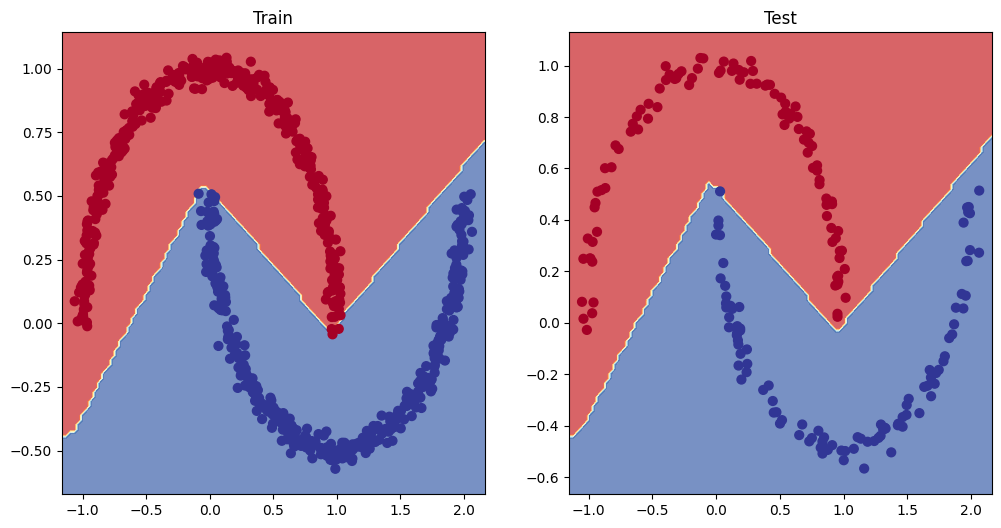

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train1, y_train1)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test1, y_test1)

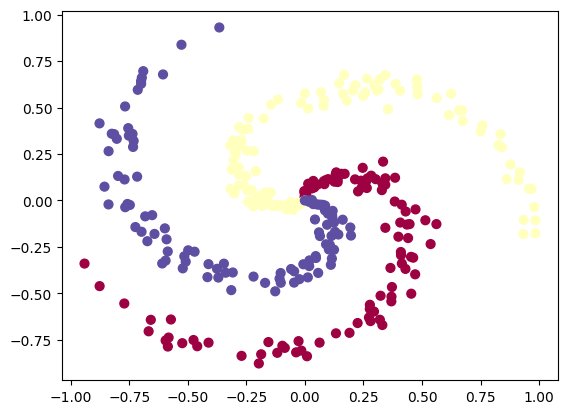

In [ ]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X2 = np.zeros((N*K,D)) # data matrix (each row = single example)
y2 = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X2[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y2[ix] = j
# lets visualize the data
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
X3 = torch.from_numpy(X2).type(torch.float)
y3 = torch.from_numpy(y2).type(torch.LongTensor)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3, y3, test_size = 0.2,
                                                    random_state = 42)

acc_fn = Accuracy(task = "multiclass", num_classes = 3).to(device)

class SpiralModelV0(nn.Module):
    def __init__(self):

        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 100)
        self.layer_2 = nn.Linear(in_features = 100, out_features = 100)
        self.layer_3 = nn.Linear(in_features = 100, out_features = 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Create an instance of BlobModel and send it to the target device
model_2 = SpiralModelV0().to(device)

loss_fn2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.01)

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs2 = 1000

# Put data to target device
X_train2, y_train2 = X_train2.to(device), y_train2.to(device)
X_test2, y_test2 = X_test2.to(device), y_test2.to(device)

for epoch in range(epochs2):
    ### Training
    model_2.train()

    # 1. Forward pass
    y_logits2 = model_2(X_train2).squeeze().to(device) # model outputs raw logits
    y_pred = torch.softmax(y_logits2, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn2(y_logits2, y_train2)
    acc = acc_fn(y_pred, y_train2)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(X_test2)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn2(test_logits, y_test2)
      test_acc = acc_fn(test_pred,
                        y_test2)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.10892, Acc: 0.32 | Test Loss: 1.02539, Test Acc: 0.50
Epoch: 100 | Loss: 0.02935, Acc: 0.99 | Test Loss: 0.00818, Test Acc: 1.00
Epoch: 200 | Loss: 0.02018, Acc: 0.99 | Test Loss: 0.00192, Test Acc: 1.00
Epoch: 300 | Loss: 0.01741, Acc: 0.99 | Test Loss: 0.00156, Test Acc: 1.00
Epoch: 400 | Loss: 0.01553, Acc: 0.99 | Test Loss: 0.00045, Test Acc: 1.00
Epoch: 500 | Loss: 0.01480, Acc: 0.99 | Test Loss: 0.00009, Test Acc: 1.00
Epoch: 600 | Loss: 0.01456, Acc: 0.99 | Test Loss: 0.00006, Test Acc: 1.00
Epoch: 700 | Loss: 0.01423, Acc: 0.99 | Test Loss: 0.00002, Test Acc: 1.00
Epoch: 800 | Loss: 0.01423, Acc: 0.99 | Test Loss: 0.00001, Test Acc: 1.00
Epoch: 900 | Loss: 0.01410, Acc: 0.99 | Test Loss: 0.00000, Test Acc: 1.00


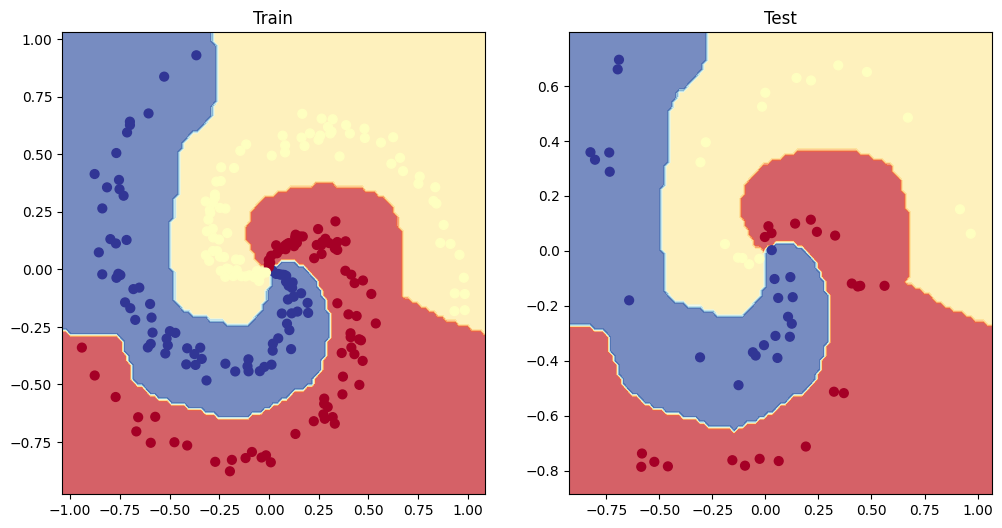

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train2, y_train2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test2, y_test2)